<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Тест-KPSS" data-toc-modified-id="Тест-KPSS-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тест KPSS</a></span></li><li><span><a href="#Расширенный-тест-Дики-—-Фуллера-ADF." data-toc-modified-id="Расширенный-тест-Дики-—-Фуллера-ADF.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Расширенный тест Дики — Фуллера ADF.</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Вывoд" data-toc-modified-id="Вывoд-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывoд</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor


from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor as cat

from lightgbm import LGBMRegressor 

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

In [6]:
df = df.sort_index()
df.index.is_monotonic

True

In [7]:
df = df.resample('1H').sum()

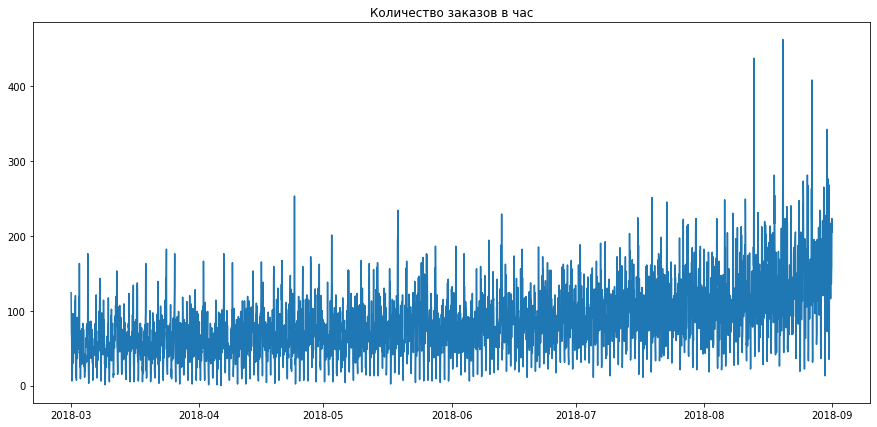

In [8]:
plt.figure(figsize=(15,7))
plt.plot(df)
plt.title('Количество заказов в час')
plt.show()


Количество заказов в час к августу месяцу увеличилось

## Анализ

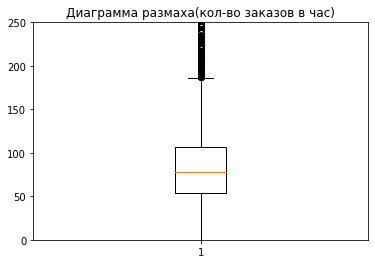

In [9]:
plt.boxplot(df['num_orders'])
plt.title('Диаграмма размаха(кол-во заказов в час)')
plt.ylim([0, 250])
plt.show()

In [10]:
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Медиана количество заказов в час находится на уровне 78,в среднем заказов в час 84.Верхняя граница выбросов 185

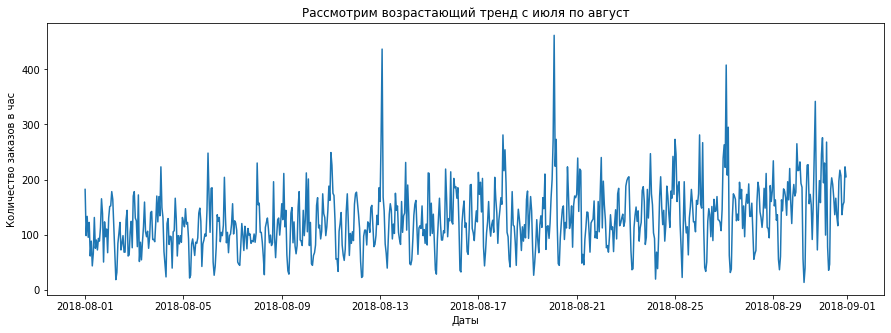

In [11]:
plt.figure(figsize=(15,5))
plt.plot(df['2018-08':'2018-09'])
plt.title('Рассмотрим возрастающий тренд с июля по август')
plt.xlabel('Даты')
plt.ylabel('Количество заказов в час')
plt.show()

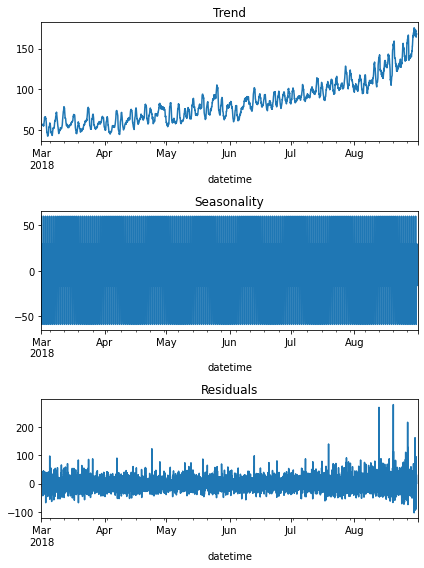

In [12]:
df = df.dropna()
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Можно увидеть восходящий тренд , к концу лета количество заказов в час становилось больше.

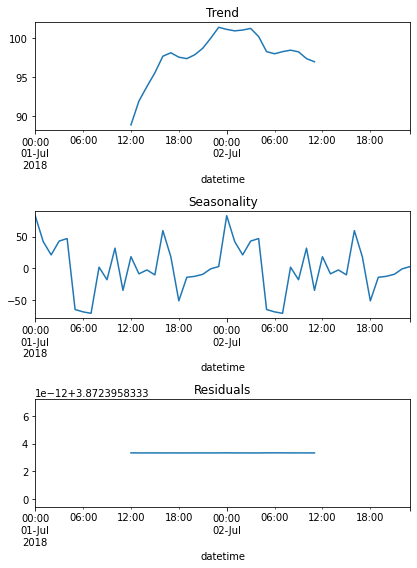

In [13]:
decomposed = seasonal_decompose(df['2018-07-01':'2018-07-02'])

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Суточная сезонность , к 00:00 количество заказов на пике,и после полуночи количество заказов снижается, ближе к 6 утра количество заказов минимально.

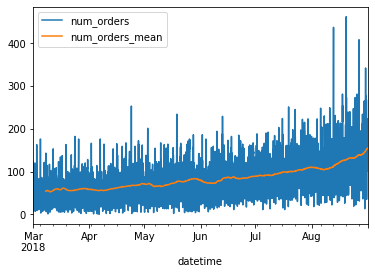

In [14]:
data = df.copy()
data['num_orders_mean'] = df['num_orders'].rolling(24*7).mean()
data.plot();

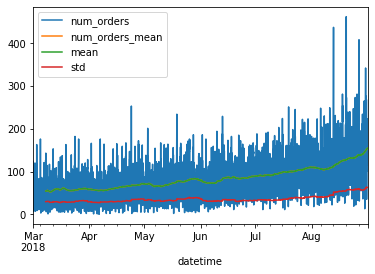

In [15]:
data['mean'] = df['num_orders'].rolling(24*7).mean()
data['std'] = df['num_orders'].rolling(24*7).std()
data.plot();

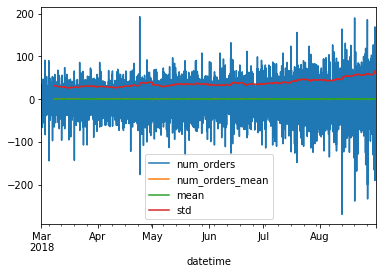

In [16]:
data = data - data.shift()
data['mean'] = data['num_orders'].rolling(24*7).mean()
data['std'] = data['num_orders'].rolling(24*7).std()
data.plot();

### Тест KPSS 

H0 - Времянные ряды стационарны.  
H1 - Времянные ряды нестационарны.  
Если p-значение теста меньше некоторого уровня значимости, то мы отвергаем нулевую гипотезу и приходим к выводу, что временные ряды не являются стационарными.

In [17]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

kpss_test(df['num_orders'])

Results of KPSS Test:
Test Statistic           10.913353
p-value                   0.010000
Lags Used                32.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Так как p-value = 0.010000,это меньше Critical Value,значит что времянные ряды стационарны.

### Расширенный тест Дики — Фуллера ADF.

H0 - Времянные ряды нестационарны.  
H1 - Времянные ряды стационарны.  
Если тестовая статистика меньше критического значения, мы можем отвергнуть нулевую гипотезу.Когда статистика теста больше критического значения, мы не можем отклонить нулевую гипотезу.

In [18]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


adf_test(df['num_orders'])

Results of Dickey-Fuller Test:
Test Statistic                   -3.068924
p-value                           0.028940
#Lags Used                       30.000000
Number of Observations Used    4385.000000
Critical Value (1%)              -3.431842
Critical Value (5%)              -2.862199
Critical Value (10%)             -2.567121
dtype: float64


Так как Test Statistic = (-3.068924),и это меньше Critical Value (5%),то мы отвергаем нулевую гипотезу.Времянные ряды стационарны.

## Обучение

In [19]:
df_new = df.copy()
def make_features(df_new, max_lag, rolling_mean_size):
    df_new['dayofweek'] = df_new.index.dayofweek
    df_new['hour'] = df_new.index.hour
    
    
    for lag in range(1, max_lag + 1):
        df_new['lag_{}'.format(lag)] = df_new['num_orders'].shift(lag)
        
    df_new['rolling_mean'] = df_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    df_new = df_new.dropna()


In [20]:
make_features(df_new, 7, 24)

In [21]:
df_new

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,168.041667


In [22]:
train,test = train_test_split(df_new,test_size=0.1,shuffle=False)
train = train.dropna()

In [23]:
train_features = train.drop('num_orders',axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders',axis=1)
test_target = test['num_orders']

In [24]:
model = LinearRegression()
model.fit(train_features,train_target)
train_predict = model.predict(train_features)
test_predict = model.predict(test_features)
print("RMSE обучающей выборки LinearRegression:", mean_squared_error(train_target,train_predict)**0.5)
print("RMSE тестовой выборки LinearRegression: ", mean_squared_error(test_target,test_predict)**0.5)

RMSE обучающей выборки LinearRegression: 30.593244861849794
RMSE тестовой выборки LinearRegression:  50.4511561709109


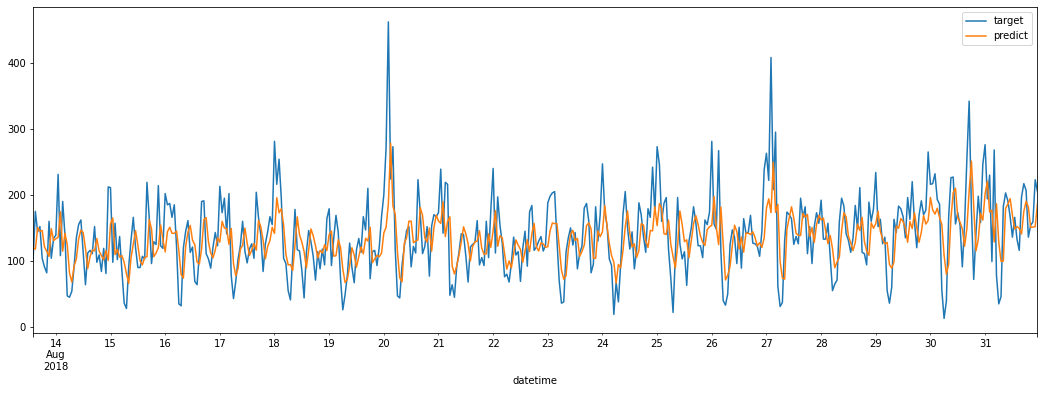

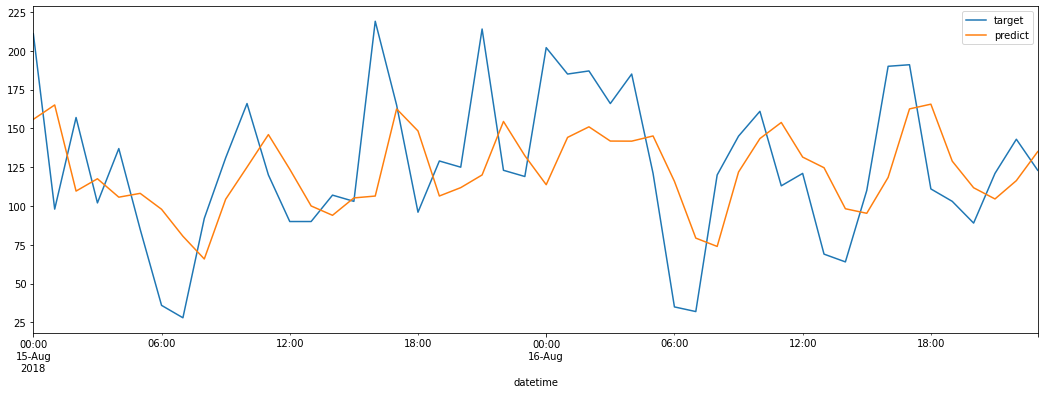

In [25]:
model_linear = pd.DataFrame({"target":test_target, "predict":test_predict})
model_linear.plot(figsize=(18, 6));
model_linear['2018-08-15':'2018-08-16'].plot(figsize=(18, 6));


In [26]:
model = RandomForestRegressor(random_state=12345)
param_dist = {'n_estimators': range(1,50),
               'max_features': range(1,10),
               'max_depth': range(1,50),
               'min_samples_split': range(2,20,2),
               'min_samples_leaf': range(2,20,2),
               'bootstrap': [True, False]}
tscv = TimeSeriesSplit(n_splits=8)
rs =  RandomizedSearchCV(model,param_distributions = param_dist, cv=tscv,scoring = mean_squared_error, verbose=3)
rs.fit(train_features, train_target)
best_params = rs.best_params_

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV 1/8] END bootstrap=True, max_depth=16, max_features=1, min_samples_leaf=14, min_samples_split=2, n_estimators=37; total time=   0.0s
[CV 2/8] END bootstrap=True, max_depth=16, max_features=1, min_samples_leaf=14, min_samples_split=2, n_estimators=37; total time=   0.1s
[CV 3/8] END bootstrap=True, max_depth=16, max_features=1, min_samples_leaf=14, min_samples_split=2, n_estimators=37; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-03-20 14:00:00     29
2018-03-20 15:00:00     74
2018-03-20 16:00:00     75
2018-03-20 17:00:00     51
2018-03-20 18:00:00     97
                      ... 
2018-04-07 15:00:00     69
2018-04-07 16:00:00    100
2018-04-07 17:00:00     36
2018-04-07 18:00:00     42
2018-04-07 19:00:00     80
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 4/8] END bootstrap=True, max_depth=16, max_features=1, min_samples_leaf=14, min_samples_split=2, n_estimators=37; total time=   0.1s
[CV 5/8] END bootstrap=True, max_depth=16, max_features=1, min_samples_leaf=14, min_samples_split=2, n_estimators=37; total time=   0.1s
[CV 6/8] END bootstrap=True, max_depth=16, max_features=1, min_samples_leaf=14, min_samples_split=2, n_estimators=37; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-06-01 14:00:00     48
2018-06-01 15:00:00     46
2018-06-01 16:00:00     72
2018-06-01 17:00:00    103
2018-06-01 18:00:00     60
                      ... 
2018-06-19 15:00:00     70
2018-06-19 16:00:00    111
2018-06-19 17:00:00    125
2018-06-19 18:00:00     82
2018-06-19 19:00:00     47
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 7/8] END bootstrap=True, max_depth=16, max_features=1, min_samples_leaf=14, min_samples_split=2, n_estimators=37; total time=   0.1s
[CV 8/8] END bootstrap=True, max_depth=16, max_features=1, min_samples_leaf=14, min_samples_split=2, n_estimators=37; total time=   0.1s
[CV 1/8] END bootstrap=True, max_depth=13, max_features=2, min_samples_leaf=12, min_samples_split=18, n_estimators=34; total time=   0.0s
[CV 2/8] END bootstrap=True, max_depth=13, max_features=2, min_samples_leaf=12, min_samples_split=18, n_estimators=34; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-07-26 08:00:00     80
2018-07-26 09:00:00    138
2018-07-26 10:00:00    142
2018-07-26 11:00:00     86
2018-07-26 12:00:00    102
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 3/8] END bootstrap=True, max_depth=13, max_features=2, min_samples_leaf=12, min_samples_split=18, n_estimators=34; total time=   0.1s
[CV 4/8] END bootstrap=True, max_depth=13, max_features=2, min_samples_leaf=12, min_samples_split=18, n_estimators=34; total time=   0.1s
[CV 5/8] END bootstrap=True, max_depth=13, max_features=2, min_samples_leaf=12, min_samples_split=18, n_estimators=34; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-05-14 08:00:00     66
2018-05-14 09:00:00     70
2018-05-14 10:00:00    123
2018-05-14 11:00:00     92
2018-05-14 12:00:00     58
                      ... 
2018-06-01 09:00:00     92
2018-06-01 10:00:00     93
2018-06-01 11:00:00    124
2018-06-01 12:00:00     69
2018-06-01 13:00:00     85
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 6/8] END bootstrap=True, max_depth=13, max_features=2, min_samples_leaf=12, min_samples_split=18, n_estimators=34; total time=   0.1s
[CV 7/8] END bootstrap=True, max_depth=13, max_features=2, min_samples_leaf=12, min_samples_split=18, n_estimators=34; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-07-08 02:00:00    109
2018-07-08 03:00:00    192
2018-07-08 04:00:00     82
2018-07-08 05:00:00     73
2018-07-08 06:00:00     44
                      ... 
2018-07-26 03:00:00    141
2018-07-26 04:00:00    131
2018-07-26 05:00:00     83
2018-07-26 06:00:00     21
2018-07-26 07:00:00     39
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 8/8] END bootstrap=True, max_depth=13, max_features=2, min_samples_leaf=12, min_samples_split=18, n_estimators=34; total time=   0.1s
[CV 1/8] END bootstrap=False, max_depth=40, max_features=4, min_samples_leaf=14, min_samples_split=6, n_estimators=46; total time=   0.1s
[CV 2/8] END bootstrap=False, max_depth=40, max_features=4, min_samples_leaf=14, min_samples_split=6, n_estimators=46; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-04-07 20:00:00     40
2018-04-07 21:00:00     57
2018-04-07 22:00:00     53
2018-04-07 23:00:00     46
2018-04-08 00:00:00     52
                      ... 
2018-04-25 21:00:00     88
2018-04-25 22:00:00     97
2018-04-25 23:00:00    140
2018-04-26 00:00:00    159
2018-04-26 01:00:00     51
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 3/8] END bootstrap=False, max_depth=40, max_features=4, min_samples_leaf=14, min_samples_split=6, n_estimators=46; total time=   0.1s
[CV 4/8] END bootstrap=False, max_depth=40, max_features=4, min_samples_leaf=14, min_samples_split=6, n_estimators=46; total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-05-14 08:00:00     66
2018-05-14 09:00:00     70
2018-05-14 10:00:00    123
2018-05-14 11:00:00     92
2018-05-14 12:00:00     58
                      ... 
2018-06-01 09:00:00     92
2018-06-01 10:00:00     93
2018-06-01 11:00:00    124
2018-06-01 12:00:00     69
2018-06-01 13:00:00     85
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 5/8] END bootstrap=False, max_depth=40, max_features=4, min_samples_leaf=14, min_samples_split=6, n_estimators=46; total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-06-19 20:00:00     57
2018-06-19 21:00:00     88
2018-06-19 22:00:00     64
2018-06-19 23:00:00     86
2018-06-20 00:00:00    126
                      ... 
2018-07-07 21:00:00     72
2018-07-07 22:00:00     91
2018-07-07 23:00:00    119
2018-07-08 00:00:00     99
2018-07-08 01:00:00     94
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 6/8] END bootstrap=False, max_depth=40, max_features=4, min_samples_leaf=14, min_samples_split=6, n_estimators=46; total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-07-08 02:00:00    109
2018-07-08 03:00:00    192
2018-07-08 04:00:00     82
2018-07-08 05:00:00     73
2018-07-08 06:00:00     44
                      ... 
2018-07-26 03:00:00    141
2018-07-26 04:00:00    131
2018-07-26 05:00:00     83
2018-07-26 06:00:00     21
2018-07-26 07:00:00     39
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 7/8] END bootstrap=False, max_depth=40, max_features=4, min_samples_leaf=14, min_samples_split=6, n_estimators=46; total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-07-26 08:00:00     80
2018-07-26 09:00:00    138
2018-07-26 10:00:00    142
2018-07-26 11:00:00     86
2018-07-26 12:00:00    102
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 8/8] END bootstrap=False, max_depth=40, max_features=4, min_samples_leaf=14, min_samples_split=6, n_estimators=46; total time=   0.3s
[CV 1/8] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=6, min_samples_split=12, n_estimators=23; total time=   0.1s
[CV 2/8] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=6, min_samples_split=12, n_estimators=23; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-04-26 02:00:00     73
2018-04-26 03:00:00    114
2018-04-26 04:00:00     58
2018-04-26 05:00:00     19
2018-04-26 06:00:00      7
                      ... 
2018-05-14 03:00:00    129
2018-05-14 04:00:00     58
2018-05-14 05:00:00     30
2018-05-14 06:00:00     13
2018-05-14 07:00:00     42
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 3/8] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=6, min_samples_split=12, n_estimators=23; total time=   0.1s
[CV 4/8] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=6, min_samples_split=12, n_estimators=23; total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-06-01 14:00:00     48
2018-06-01 15:00:00     46
2018-06-01 16:00:00     72
2018-06-01 17:00:00    103
2018-06-01 18:00:00     60
                      ... 
2018-06-19 15:00:00     70
2018-06-19 16:00:00    111
2018-06-19 17:00:00    125
2018-06-19 18:00:00     82
2018-06-19 19:00:00     47
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 5/8] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=6, min_samples_split=12, n_estimators=23; total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-06-19 20:00:00     57
2018-06-19 21:00:00     88
2018-06-19 22:00:00     64
2018-06-19 23:00:00     86
2018-06-20 00:00:00    126
                      ... 
2018-07-07 21:00:00     72
2018-07-07 22:00:00     91
2018-07-07 23:00:00    119
2018-07-08 00:00:00     99
2018-07-08 01:00:00     94
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 6/8] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=6, min_samples_split=12, n_estimators=23; total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-07-08 02:00:00    109
2018-07-08 03:00:00    192
2018-07-08 04:00:00     82
2018-07-08 05:00:00     73
2018-07-08 06:00:00     44
                      ... 
2018-07-26 03:00:00    141
2018-07-26 04:00:00    131
2018-07-26 05:00:00     83
2018-07-26 06:00:00     21
2018-07-26 07:00:00     39
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 7/8] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=6, min_samples_split=12, n_estimators=23; total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-07-26 08:00:00     80
2018-07-26 09:00:00    138
2018-07-26 10:00:00    142
2018-07-26 11:00:00     86
2018-07-26 12:00:00    102
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 8/8] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=6, min_samples_split=12, n_estimators=23; total time=   0.4s
[CV 1/8] END bootstrap=False, max_depth=37, max_features=8, min_samples_leaf=4, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 2/8] END bootstrap=False, max_depth=37, max_features=8, min_samples_leaf=4, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 3/8] END bootstrap=False, max_depth=37, max_features=8, min_samples_leaf=4, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 4/8] END bootstrap=False, max_depth=37, max_features=8, min_samples_leaf=4, min_samples_split=16, n_estimators=5; total time=   0.0s
[CV 5/8] END bootstrap=False, max_depth=37, max_features=8, min_samples_leaf=4, min_samples_split=16, n_estimators=5; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-06-19 20:00:00     57
2018-06-19 21:00:00     88
2018-06-19 22:00:00     64
2018-06-19 23:00:00     86
2018-06-20 00:00:00    126
                      ... 
2018-07-07 21:00:00     72
2018-07-07 22:00:00     91
2018-07-07 23:00:00    119
2018-07-08 00:00:00     99
2018-07-08 01:00:00     94
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 6/8] END bootstrap=False, max_depth=37, max_features=8, min_samples_leaf=4, min_samples_split=16, n_estimators=5; total time=   0.1s
[CV 7/8] END bootstrap=False, max_depth=37, max_features=8, min_samples_leaf=4, min_samples_split=16, n_estimators=5; total time=   0.1s
[CV 8/8] END bootstrap=False, max_depth=37, max_features=8, min_samples_leaf=4, min_samples_split=16, n_estimators=5; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-03-20 14:00:00     29
2018-03-20 15:00:00     74
2018-03-20 16:00:00     75
2018-03-20 17:00:00     51
2018-03-20 18:00:00     97
                      ... 
2018-04-07 15:00:00     69
2018-04-07 16:00:00    100
2018-04-07 17:00:00     36
2018-04-07 18:00:00     42
2018-04-07 19:00:00     80
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 1/8] END bootstrap=True, max_depth=43, max_features=9, min_samples_leaf=14, min_samples_split=8, n_estimators=46; total time=   0.1s
[CV 2/8] END bootstrap=True, max_depth=43, max_features=9, min_samples_leaf=14, min_samples_split=8, n_estimators=46; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-04-26 02:00:00     73
2018-04-26 03:00:00    114
2018-04-26 04:00:00     58
2018-04-26 05:00:00     19
2018-04-26 06:00:00      7
                      ... 
2018-05-14 03:00:00    129
2018-05-14 04:00:00     58
2018-05-14 05:00:00     30
2018-05-14 06:00:00     13
2018-05-14 07:00:00     42
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 3/8] END bootstrap=True, max_depth=43, max_features=9, min_samples_leaf=14, min_samples_split=8, n_estimators=46; total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-05-14 08:00:00     66
2018-05-14 09:00:00     70
2018-05-14 10:00:00    123
2018-05-14 11:00:00     92
2018-05-14 12:00:00     58
                      ... 
2018-06-01 09:00:00     92
2018-06-01 10:00:00     93
2018-06-01 11:00:00    124
2018-06-01 12:00:00     69
2018-06-01 13:00:00     85
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 4/8] END bootstrap=True, max_depth=43, max_features=9, min_samples_leaf=14, min_samples_split=8, n_estimators=46; total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-06-01 14:00:00     48
2018-06-01 15:00:00     46
2018-06-01 16:00:00     72
2018-06-01 17:00:00    103
2018-06-01 18:00:00     60
                      ... 
2018-06-19 15:00:00     70
2018-06-19 16:00:00    111
2018-06-19 17:00:00    125
2018-06-19 18:00:00     82
2018-06-19 19:00:00     47
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 5/8] END bootstrap=True, max_depth=43, max_features=9, min_samples_leaf=14, min_samples_split=8, n_estimators=46; total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-06-19 20:00:00     57
2018-06-19 21:00:00     88
2018-06-19 22:00:00     64
2018-06-19 23:00:00     86
2018-06-20 00:00:00    126
                      ... 
2018-07-07 21:00:00     72
2018-07-07 22:00:00     91
2018-07-07 23:00:00    119
2018-07-08 00:00:00     99
2018-07-08 01:00:00     94
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 6/8] END bootstrap=True, max_depth=43, max_features=9, min_samples_leaf=14, min_samples_split=8, n_estimators=46; total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-07-08 02:00:00    109
2018-07-08 03:00:00    192
2018-07-08 04:00:00     82
2018-07-08 05:00:00     73
2018-07-08 06:00:00     44
                      ... 
2018-07-26 03:00:00    141
2018-07-26 04:00:00    131
2018-07-26 05:00:00     83
2018-07-26 06:00:00     21
2018-07-26 07:00:00     39
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 7/8] END bootstrap=True, max_depth=43, max_features=9, min_samples_leaf=14, min_samples_split=8, n_estimators=46; total time=   0.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-07-26 08:00:00     80
2018-07-26 09:00:00    138
2018-07-26 10:00:00    142
2018-07-26 11:00:00     86
2018-07-26 12:00:00    102
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 8/8] END bootstrap=True, max_depth=43, max_features=9, min_samples_leaf=14, min_samples_split=8, n_estimators=46; total time=   0.4s
[CV 1/8] END bootstrap=False, max_depth=46, max_features=1, min_samples_leaf=18, min_samples_split=12, n_estimators=41; total time=   0.0s
[CV 2/8] END bootstrap=False, max_depth=46, max_features=1, min_samples_leaf=18, min_samples_split=12, n_estimators=41; total time=   0.0s
[CV 3/8] END bootstrap=False, max_depth=46, max_features=1, min_samples_leaf=18, min_samples_split=12, n_estimators=41; total time=   0.1s
[CV 4/8] END bootstrap=False, max_depth=46, max_features=1, min_samples_leaf=18, min_samples_split=12, n_estimators=41; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-06-01 14:00:00     48
2018-06-01 15:00:00     46
2018-06-01 16:00:00     72
2018-06-01 17:00:00    103
2018-06-01 18:00:00     60
                      ... 
2018-06-19 15:00:00     70
2018-06-19 16:00:00    111
2018-06-19 17:00:00    125
2018-06-19 18:00:00     82
2018-06-19 19:00:00     47
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 5/8] END bootstrap=False, max_depth=46, max_features=1, min_samples_leaf=18, min_samples_split=12, n_estimators=41; total time=   0.1s
[CV 6/8] END bootstrap=False, max_depth=46, max_features=1, min_samples_leaf=18, min_samples_split=12, n_estimators=41; total time=   0.1s
[CV 7/8] END bootstrap=False, max_depth=46, max_features=1, min_samples_leaf=18, min_samples_split=12, n_estimators=41; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-07-26 08:00:00     80
2018-07-26 09:00:00    138
2018-07-26 10:00:00    142
2018-07-26 11:00:00     86
2018-07-26 12:00:00    102
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 8/8] END bootstrap=False, max_depth=46, max_features=1, min_samples_leaf=18, min_samples_split=12, n_estimators=41; total time=   0.1s
[CV 1/8] END bootstrap=False, max_depth=16, max_features=1, min_samples_leaf=4, min_samples_split=14, n_estimators=36; total time=   0.0s
[CV 2/8] END bootstrap=False, max_depth=16, max_features=1, min_samples_leaf=4, min_samples_split=14, n_estimators=36; total time=   0.0s
[CV 3/8] END bootstrap=False, max_depth=16, max_features=1, min_samples_leaf=4, min_samples_split=14, n_estimators=36; total time=   0.1s
[CV 4/8] END bootstrap=False, max_depth=16, max_features=1, min_samples_leaf=4, min_samples_split=14, n_estimators=36; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-05-14 08:00:00     66
2018-05-14 09:00:00     70
2018-05-14 10:00:00    123
2018-05-14 11:00:00     92
2018-05-14 12:00:00     58
                      ... 
2018-06-01 09:00:00     92
2018-06-01 10:00:00     93
2018-06-01 11:00:00    124
2018-06-01 12:00:00     69
2018-06-01 13:00:00     85
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 5/8] END bootstrap=False, max_depth=16, max_features=1, min_samples_leaf=4, min_samples_split=14, n_estimators=36; total time=   0.1s
[CV 6/8] END bootstrap=False, max_depth=16, max_features=1, min_samples_leaf=4, min_samples_split=14, n_estimators=36; total time=   0.1s
[CV 7/8] END bootstrap=False, max_depth=16, max_features=1, min_samples_leaf=4, min_samples_split=14, n_estimators=36; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-07-08 02:00:00    109
2018-07-08 03:00:00    192
2018-07-08 04:00:00     82
2018-07-08 05:00:00     73
2018-07-08 06:00:00     44
                      ... 
2018-07-26 03:00:00    141
2018-07-26 04:00:00    131
2018-07-26 05:00:00     83
2018-07-26 06:00:00     21
2018-07-26 07:00:00     39
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 8/8] END bootstrap=False, max_depth=16, max_features=1, min_samples_leaf=4, min_samples_split=14, n_estimators=36; total time=   0.1s
[CV 1/8] END bootstrap=False, max_depth=31, max_features=6, min_samples_leaf=2, min_samples_split=16, n_estimators=27; total time=   0.1s
[CV 2/8] END bootstrap=False, max_depth=31, max_features=6, min_samples_leaf=2, min_samples_split=16, n_estimators=27; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-04-07 20:00:00     40
2018-04-07 21:00:00     57
2018-04-07 22:00:00     53
2018-04-07 23:00:00     46
2018-04-08 00:00:00     52
                      ... 
2018-04-25 21:00:00     88
2018-04-25 22:00:00     97
2018-04-25 23:00:00    140
2018-04-26 00:00:00    159
2018-04-26 01:00:00     51
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 3/8] END bootstrap=False, max_depth=31, max_features=6, min_samples_leaf=2, min_samples_split=16, n_estimators=27; total time=   0.1s
[CV 4/8] END bootstrap=False, max_depth=31, max_features=6, min_samples_leaf=2, min_samples_split=16, n_estimators=27; total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-05-14 08:00:00     66
2018-05-14 09:00:00     70
2018-05-14 10:00:00    123
2018-05-14 11:00:00     92
2018-05-14 12:00:00     58
                      ... 
2018-06-01 09:00:00     92
2018-06-01 10:00:00     93
2018-06-01 11:00:00    124
2018-06-01 12:00:00     69
2018-06-01 13:00:00     85
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 5/8] END bootstrap=False, max_depth=31, max_features=6, min_samples_leaf=2, min_samples_split=16, n_estimators=27; total time=   0.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-06-19 20:00:00     57
2018-06-19 21:00:00     88
2018-06-19 22:00:00     64
2018-06-19 23:00:00     86
2018-06-20 00:00:00    126
                      ... 
2018-07-07 21:00:00     72
2018-07-07 22:00:00     91
2018-07-07 23:00:00    119
2018-07-08 00:00:00     99
2018-07-08 01:00:00     94
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 6/8] END bootstrap=False, max_depth=31, max_features=6, min_samples_leaf=2, min_samples_split=16, n_estimators=27; total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-07-08 02:00:00    109
2018-07-08 03:00:00    192
2018-07-08 04:00:00     82
2018-07-08 05:00:00     73
2018-07-08 06:00:00     44
                      ... 
2018-07-26 03:00:00    141
2018-07-26 04:00:00    131
2018-07-26 05:00:00     83
2018-07-26 06:00:00     21
2018-07-26 07:00:00     39
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 7/8] END bootstrap=False, max_depth=31, max_features=6, min_samples_leaf=2, min_samples_split=16, n_estimators=27; total time=   0.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-07-26 08:00:00     80
2018-07-26 09:00:00    138
2018-07-26 10:00:00    142
2018-07-26 11:00:00     86
2018-07-26 12:00:00    102
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 8/8] END bootstrap=False, max_depth=31, max_features=6, min_samples_leaf=2, min_samples_split=16, n_estimators=27; total time=   0.3s
[CV 1/8] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=16, min_samples_split=10, n_estimators=21; total time=   0.0s
[CV 2/8] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=16, min_samples_split=10, n_estimators=21; total time=   0.0s
[CV 3/8] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=16, min_samples_split=10, n_estimators=21; total time=   0.0s
[CV 4/8] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=16, min_samples_split=10, n_estimators=21; total time=   0.0s
[CV 5/8] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=16, min_samples_split=10, n_estimators=21; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=datetime
2018-06-19 20:00:00     57
2018-06-19 21:00:00     88
2018-06-19 22:00:00     64
2018-06-19 23:00:00     86
2018-06-20 00:00:00    126
                      ... 
2018-07-07 21:00:00     72
2018-07-07 22:00:00     91
2018-07-07 23:00:00    119
2018-07-08 00:00:00     99
2018-07-08 01:00:00     94
Freq: H, Name: num_orders, Length: 438, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores

[CV 6/8] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=16, min_samples_split=10, n_estimators=21; total time=   0.1s
[CV 7/8] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=16, min_samples_split=10, n_estimators=21; total time=   0.1s
[CV 8/8] END bootstrap=True, max_depth=9, max_features=2, min_samples_leaf=16, min_samples_split=10, n_estimators=21; total time=   0.1s


In [27]:
model = RandomForestRegressor(**best_params)
model.fit(train_features,train_target)
train_predict = model.predict(train_features)
test_predict = model.predict(test_features)
print("RMSE обучающей выборки для RandomForestRegresso:", mean_squared_error(train_target,train_predict)**0.5)
print("RMSE тестовой выборки для RandomForestRegresso: ", mean_squared_error(test_target,test_predict)**0.5)

RMSE обучающей выборки для RandomForestRegresso: 24.960077452168484
RMSE тестовой выборки для RandomForestRegresso:  64.93931148208183


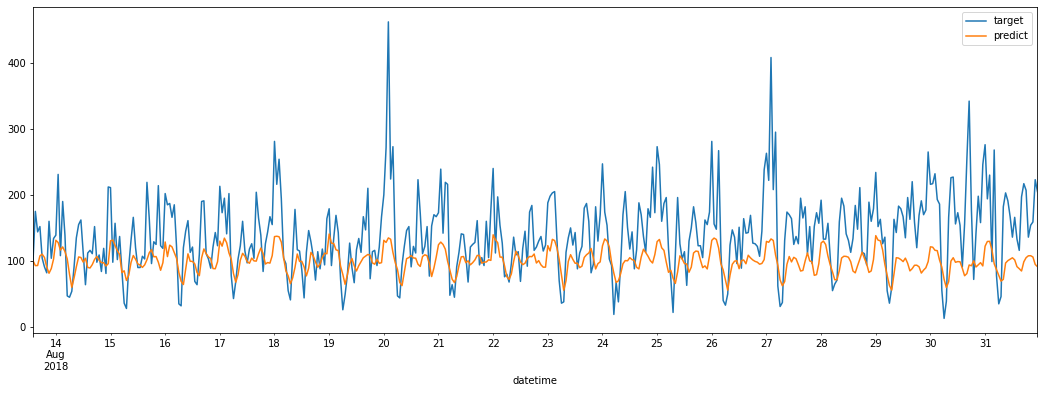

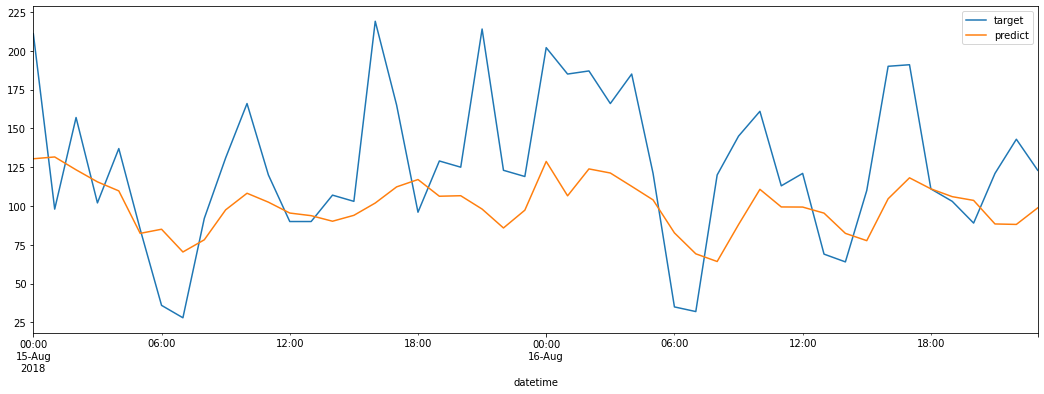

In [28]:
model_random = pd.DataFrame({"target":test_target, "predict":test_predict})
model_random.plot(figsize=(18, 6));
model_random['2018-08-15':'2018-08-16'].plot(figsize=(18, 6));


In [ ]:
model = cat(loss_function='RMSE',random_state=12345,verbose=10)
params = {'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
        'depth': [4, 6, 8, 10, 13, 15, 25,35],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'n_estimators' : [10, 30]}
tscv = TimeSeriesSplit(n_splits=5)
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(train_features, train_target)
print('Best hyperparams: ', grid_cv.best_params_)
params_best =  grid_cv.best_params_
print('RMSE score on train sample: {:.2f}'.format((grid_cv.best_score_) ** 0.5))

0:	learn: 29.5336111	total: 47.1ms	remaining: 424ms
9:	learn: 28.3355149	total: 52.2ms	remaining: 0us
0:	learn: 30.2293678	total: 1.17ms	remaining: 10.5ms
9:	learn: 29.2229702	total: 7.65ms	remaining: 0us
0:	learn: 31.8905543	total: 1.03ms	remaining: 9.32ms
9:	learn: 30.9051733	total: 8.21ms	remaining: 0us
0:	learn: 33.2467495	total: 1.14ms	remaining: 10.2ms
9:	learn: 32.1795353	total: 9.79ms	remaining: 0us
0:	learn: 34.6566911	total: 1.73ms	remaining: 15.6ms
9:	learn: 33.4324655	total: 12.1ms	remaining: 0us
0:	learn: 29.5336111	total: 653us	remaining: 18.9ms
10:	learn: 28.2059532	total: 6.42ms	remaining: 11.1ms
20:	learn: 27.0897735	total: 12.4ms	remaining: 5.33ms
29:	learn: 26.1336890	total: 20.3ms	remaining: 0us
0:	learn: 30.2293678	total: 715us	remaining: 20.7ms
10:	learn: 29.1067922	total: 7.95ms	remaining: 13.7ms
20:	learn: 28.1682880	total: 15.1ms	remaining: 6.48ms
29:	learn: 27.3481659	total: 21.7ms	remaining: 0us
0:	learn: 31.8905543	total: 977us	remaining: 28.3ms
10:	learn: 3

In [ ]:
model = cat(**params_best)
model.fit(train_features, train_target)
predict_test = model.predict(test_features)
predict_train = model.predict(train_features)
print('RMSE обучающей выборки CatBoostRegressor:',mean_squared_error(train_target, predict_train)**0.5)
print('RMSE тестовой выборки CatBoostRegressor:',mean_squared_error(test_target, predict_test)**0.5)

In [ ]:
model_cat = pd.DataFrame({"target":test_target, "predict":predict_test})
model_cat.plot(figsize=(18, 6));
model_cat['2018-08-15':'2018-08-16'].plot(figsize=(18, 6));

In [ ]:
model = LGBMRegressor()
params = {'n_estimators' : [10, 30],
        'max_depth' : [3, 5, 6, 7, 9, 12, 15, 17, 25],
        'random_state' : [12345],
        'num_leaves' : [31],
        'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1]}
tscv = TimeSeriesSplit(n_splits=5)
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(train_features, train_target)
print('Best hyperparams: ', grid_cv.best_params_)
parameters = grid_cv.best_params_
print('RMSE score on train sample: {:.2f}'.format((grid_cv.best_score_) ** 0.5))

In [ ]:
model = LGBMRegressor(**parameters)
model.fit(train_features, train_target)
predict_test = model.predict(test_features)
predict_train = model.predict(train_features)
print('RMSE обучающей выборки LGBMRegressor:',mean_squared_error(train_target, predict_train)**0.5)
print('RMSE тестовой выборки LGBMRegressor:',mean_squared_error(test_target, predict_test)**0.5)

In [ ]:
model_LGBMR = pd.DataFrame({"target":test_target, "predict":predict_test})
model_LGBMR.plot(figsize=(18, 6));
model_LGBMR['2018-08-15':'2018-08-16'].plot(figsize=(18, 6));

## Вывoд

1.На этапе подготовки данных,дынные расположены хронологическом порядке, выполнено ресемплирование по одному часу.  
2.На этапе анализа данных выявлено:  
Количество заказов в концу лета увеличилось.  
Пик заказов ближе к полуночи,минимум около 6 утра.  
Проведено два теста на проверку стационарности времянного ряда,времянные ряды стационарны.  
3.Для обучения выбрано 4 модели:  LGBMRegressor,RandomForestRegressor,LinearRegression,CatBoostRegressor  
Добавлены новые факторы:  
День недели,  
Час,  
max_lag(влияние событий на сегодняшние) = 7,  
rolling_mean_size(окно сглаживание) = 24   
4.Результаты моделей RMSE тестовой выборки:  
    RMSE тестовой выборки LinearRegression:  50.4511561709109
    RMSE тестовой выборки для RandomForestRegresso:  45.705509226274046
    RMSE тестовой выборки CatBoostRegressor: 53.37750364177944
    RMSE тестовой выборки LGBMRegressor: 46.91959816813104 
 
Наилучший показатель RMSE в данном случае у RandomForestRegressor.
    